In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:

dt = pd.read_csv('/content/drive/MyDrive/pdm_data.csv')

for column in dt.columns:
    if dt[column].dtype != object:
        max_value = dt[column].max()
        min_value = dt[column].min()
        print("Column_name", column)
        print("Max : ", max_value)
        print("Min: ", min_value)
        print("------------")

Column_name gadget_id
Max :  6
Min:  1
------------
Column_name vibration_x
Max :  10
Min:  1
------------
Column_name vibration_y
Max :  10
Min:  0
------------
Column_name pressure
Max :  20.0
Min:  10.0
------------
Column_name temperature
Max :  109.81648987584217
Min:  11.46314657225104
------------
Column_name Unnamed: 10
Max :  nan
Min:  nan
------------
Column_name Unnamed: 11
Max :  nan
Min:  nan
------------


In [9]:
df_data = pd.read_csv('/content/drive/MyDrive/pdm_data.csv',parse_dates=['measurement_time','failure_time'])
df_data.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time
0,2020-07-15,1,3,7,16.0,44.114437,NaN,NaN,2020-07-15 09:56:03.974006640
1,2020-07-15,3,3,8,11.0,40.427740,NaN,NaN,2020-07-15 09:33:48.330967860
2,2020-07-15,2,3,10,16.0,22.300000,NaN,NaN,2020-07-15 07:11:50.319233260
3,2020-07-15,6,7,6,12.0,75.874521,NaN,NaN,2020-07-16 16:05:31.427141800
4,2020-07-15,5,4,7,12.0,81.125342,NaN,NaN,2020-07-15 05:48:58.383388460


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   measurement_time  1008 non-null   datetime64[ns]
 1   gadget_id         1008 non-null   int64         
 2   vibration_x       1008 non-null   int64         
 3   vibration_y       1008 non-null   int64         
 4   pressure          1008 non-null   float64       
 5   temperature       1008 non-null   float64       
 6   Unnamed: 10       0 non-null      float64       
 7   Unnamed: 11       0 non-null      float64       
 8   failure_time      916 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 71.0 KB


In [7]:
n_rows = 20000
measurement_date_range = pd.date_range(start='2020-06-01', end='2020-07-31', periods=n_rows)
gadget_id_range = np.random.randint(1, 6, size=n_rows)
vibration_x_range = np.random.randint(1, 11, size=n_rows)
vibration_y_range = np.random.randint(0, 11, size=n_rows)
pressure_range = np.random.uniform(10.0, 20.0, size=n_rows)
temperature_range = np.random.uniform(11.46314657225104, 109.81648987584217, size=n_rows)

measurement_time_range = pd.date_range(start='2020-06-01 00:00:00', end='2020-07-31 23:59:59', periods=n_rows).time
measurement_time_range = [str(time) for time in measurement_time_range]
measurement_time_range = np.random.choice(measurement_time_range, size=n_rows, replace=True)
measurement_time_range = [str(date) + ' ' + time for date, time in zip(measurement_date_range.date, measurement_time_range)]

failure_hour_range = np.random.choice(range(24), size=n_rows, replace=True)
failure_minute_range = np.random.choice(range(60), size=n_rows, replace=True)
failure_second_range = np.random.choice(range(60), size=n_rows, replace=True)

failure_time_range = [
    str(date.date()) + ' ' + f'{hh:02d}:{mm:02d}:{ss:02d}'
    for date, hh, mm, ss in zip(
        pd.to_datetime(measurement_time_range),
        failure_hour_range,
        failure_minute_range,
        failure_second_range
    )
]


dft = pd.DataFrame({
    'measurement_time': measurement_time_range,
    'gadget_id': gadget_id_range,
    'vibration_x': vibration_x_range,
    'vibration_y': vibration_y_range,
    'pressure': pressure_range,
    'temperature': temperature_range,
    'failure_time': failure_time_range
})

dft['failure_time'] = pd.to_datetime(dft['failure_time'])
dft['measurement_time'] = pd.to_datetime(dft['measurement_time'])


time_diff = dft['failure_time'] - dft['measurement_time']

dft = dft[(time_diff <= pd.Timedelta(hours=3)) & (dft['failure_time'].dt.strftime('%p') == dft['measurement_time'].dt.strftime('%p'))]

dft = dft[dft['measurement_time'] < dft['failure_time']]


dft.to_csv('/content/drive/MyDrive/synthetic_data.csv', index=False)


In [5]:
df_data2 = pd.read_csv('/content/drive/MyDrive/synthetic_data.csv',parse_dates=['measurement_time','failure_time'])
df_data2.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,failure_time
0,2020-06-01 18:45:45.392239,2,9,5,11.175012,107.427798,2020-06-01 21:16:56
1,2020-06-01 06:43:39.747274,4,5,10,11.870062,107.610080,2020-06-01 07:22:02
2,2020-06-01 17:19:29.679567,2,5,0,15.231024,42.215536,2020-06-01 18:10:16
3,2020-06-01 00:05:53.340934,2,8,4,12.904577,11.887432,2020-06-01 00:19:55
4,2020-06-01 18:07:44.270127,3,9,4,13.994750,23.623499,2020-06-01 20:02:35


In [8]:
df_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   measurement_time  1121 non-null   datetime64[ns]
 1   gadget_id         1121 non-null   int64         
 2   vibration_x       1121 non-null   int64         
 3   vibration_y       1121 non-null   int64         
 4   pressure          1121 non-null   float64       
 5   temperature       1121 non-null   float64       
 6   failure_time      1121 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3)
memory usage: 61.4 KB


In [10]:
merged_df = pd.concat([df_data2, df_data])

merged_df.to_csv('/content/drive/MyDrive/merged_data.csv', index=False)

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129 entries, 0 to 1007
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   measurement_time  2129 non-null   datetime64[ns]
 1   gadget_id         2129 non-null   int64         
 2   vibration_x       2129 non-null   int64         
 3   vibration_y       2129 non-null   int64         
 4   pressure          2129 non-null   float64       
 5   temperature       2129 non-null   float64       
 6   failure_time      2037 non-null   datetime64[ns]
 7   Unnamed: 10       0 non-null      float64       
 8   Unnamed: 11       0 non-null      float64       
dtypes: datetime64[ns](2), float64(4), int64(3)
memory usage: 166.3 KB


In [14]:
df_data3 = pd.read_csv('/content/drive/MyDrive/merged_data.csv',parse_dates=['measurement_time','failure_time'])

In [16]:
df_data3['time_to_fail'] = df_data3['failure_time'] - df_data3['measurement_time']
df_data3['fail_in_1h'] = np.where(df_data3['time_to_fail']<pd.Timedelta(hours=1), 1, 0)
df_data3.head()


,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,failure_time,Unnamed: 10,Unnamed: 11,time_to_fail,fail_in_1h
0,2020-06-01 18:45:45.392239,2,9,5,11.175012,107.427798,2020-06-01 21:16:56,NaN,NaN,0 days 02:31:10.607761,0
1,2020-06-01 06:43:39.747274,4,5,10,11.870062,107.610080,2020-06-01 07:22:02,NaN,NaN,0 days 00:38:22.252726,1
2,2020-06-01 17:19:29.679567,2,5,0,15.231024,42.215536,2020-06-01 18:10:16,NaN,NaN,0 days 00:50:46.320433,1
3,2020-06-01 00:05:53.340934,2,8,4,12.904577,11.887432,2020-06-01 00:19:55,NaN,NaN,0 days 00:14:01.659066,1
4,2020-06-01 18:07:44.270127,3,9,4,13.994750,23.623499,2020-06-01 20:02:35,NaN,NaN,0 days 01:54:50.729873,0


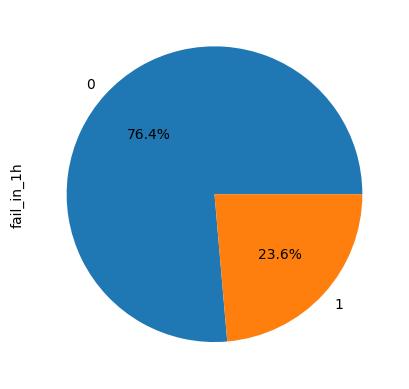

In [18]:
df_data3['fail_in_1h'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

In [19]:
df_data3 = df_data3.reset_index(drop=True)
df_data3 = df_data3.sort_values(by=['gadget_id', 'measurement_time'], ascending=[True, True])
df_data3['temperature_6h_std'] = df_data3.groupby('gadget_id')['temperature'].rolling(6).std(ddof=0).reset_index(drop=True)
df_data3['pressure_6h_mean'] = df_data3.groupby('gadget_id')['pressure'].rolling(6).mean().reset_index(drop=True)

In [20]:
df_data3.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,failure_time,Unnamed: 10,Unnamed: 11,time_to_fail,fail_in_1h,temperature_6h_std,pressure_6h_mean
11,2020-06-01 14:12:24.658265,1,4,1,18.205613,58.183295,2020-06-01 16:18:37,NaN,NaN,0 days 02:06:12.341735,0,17.268688,14.470968
18,2020-06-02 00:36:51.421442,1,3,10,12.486869,43.376025,2020-06-02 02:58:12,NaN,NaN,0 days 02:21:20.578558,0,32.450953,13.781087
28,2020-06-02 05:25:19.101710,1,6,5,12.497098,28.002291,2020-06-02 07:52:43,NaN,NaN,0 days 02:27:23.898290,0,24.667384,14.257081
32,2020-06-02 05:38:42.996999,1,3,6,19.585990,42.984339,2020-06-02 08:09:38,NaN,NaN,0 days 02:30:55.003001,0,27.339101,16.367219
26,2020-06-02 08:01:26.042504,1,9,9,12.599291,23.711024,2020-06-02 09:54:32,NaN,NaN,0 days 01:53:05.957496,0,14.790393,13.868110


In [21]:
X = ['vibration_y', 'pressure_6h_mean', 'temperature_6h_std']
y = 'fail_in_1h'
cols = X + [y]

df_edited = df_data3.copy()
df_edited = df_edited.dropna(subset=cols)
df_edited = df_edited.reset_index(drop=True)


In [22]:
binner = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
binner.fit(df_edited[X])
arr_bins= binner.transform(df_edited[X])
df_bins = pd.DataFrame(arr_bins)

X = list(df_bins.columns)
cols = X + [y]

df = pd.concat([df_edited, df_bins], axis=1)

df_train = df[df['gadget_id'].isin([1,2,3,4])].reset_index(drop=True).copy()
df_test = df[df['gadget_id'].isin([5,6])].reset_index(drop=True).copy()

print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")

Training data: (1544, 43)
Test data: (555, 43)


In [26]:
model_cb = CatBoostClassifier(iterations=10000, learning_rate=0.2, depth=12)
model_rf = RandomForestClassifier(n_estimators=500, random_state=50)
final_estimator = LogisticRegression()

estimators = [('catboost', model_cb), ('randomforest', model_rf)]
stacked_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

stacked_model.fit(df_train[X], df_train[y])

predictions = stacked_model.predict(df_test[X])

accuracy = accuracy_score(df_test[y], predictions)
print(f"accuracy : {accuracy * 100:.2f}%")

Streaming output truncated to the last 5000 lines.
5001:	learn: 0.2359837	total: 27s	remaining: 26.9s
5002:	learn: 0.2359836	total: 27s	remaining: 26.9s
5003:	learn: 0.2359836	total: 27s	remaining: 26.9s
5004:	learn: 0.2359837	total: 27s	remaining: 26.9s
5005:	learn: 0.2359835	total: 27s	remaining: 26.9s
5006:	learn: 0.2359833	total: 27s	remaining: 26.9s
5007:	learn: 0.2359833	total: 27s	remaining: 26.9s
5008:	learn: 0.2359833	total: 27s	remaining: 26.9s
5009:	learn: 0.2359833	total: 27s	remaining: 26.9s
5010:	learn: 0.2359833	total: 27s	remaining: 26.9s
5011:	learn: 0.2359833	total: 27s	remaining: 26.9s
5012:	learn: 0.2359833	total: 27s	remaining: 26.9s
5013:	learn: 0.2359835	total: 27s	remaining: 26.9s
5014:	learn: 0.2359833	total: 27s	remaining: 26.9s
5015:	learn: 0.2359833	total: 27s	remaining: 26.9s
5016:	learn: 0.2359834	total: 27s	remaining: 26.8s
5017:	learn: 0.2359834	total: 27s	remaining: 26.8s
5018:	learn: 0.2359834	total: 27s	remaining: 26.8s
5019:	learn: 0.2359834	total: 2

In [25]:
joblib.dump(stacked_model, '/content/drive/MyDrive/pdm_model2.pkl')
print("Saved")

Saved


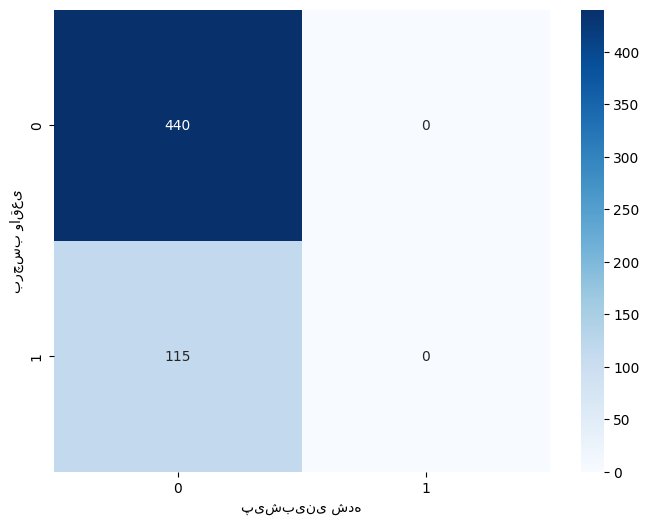

In [28]:
cm = confusion_matrix(df_test[y], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('پیش‌بینی شده')
plt.ylabel('برچسب واقعی')
plt.show()